In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

from hmm import hmm_clustering
from m_k_means import MKMeans, m_k_means, m_lift_function 
from w_k_means import WassersteinKMeans, w_k_means, w_lift_function
from data_generator import *
from utils.pre_processing_utils import *
from utils.accuracy_utils import *
from utils.io_utils import ensure_directory_exists, save_validation_results


# GBM parameters
gbm_par = np.array(
    [[0.02, 0.2], #mu,sigma *bull-regime*
    [-0.02, 0.3]]) #mu,sigma *bear-regime*

# MJD parameters
mjd_par = np.array(
    [[0.05, 0.2, 5, 0.02, 0.0125], # (mu,sigma, lambda, gamma, delta) bull-regime
    [-0.05, 0.4, 10, -0.04, 0.1]]) # (mu,sigma, lambda, gamma, delta) bear-regime

In [ ]:
def price_path_plot(t, prices, regimes):

    plt.plot(t,prices)

    # plot of regime changes
    for i in range(10):
        if i == 0:
            plt.axvspan(t[regimes[i][0]], t[regimes[i][-1]], color='red', alpha=0.3, label='regime changes')
            
        else:
            plt.axvspan(t[regimes[i][0]], t[regimes[i][-1]], color='red', alpha=0.3)
            
        
    plt.xlabel("time (years)")
    plt.ylabel("stock price")
    plt.legend()
    plt.show()

In [ ]:
# validation for W k-means on synthetic data
def synthetic_w_validation(path, h1, h2, p, max_iter, tol, N_trials):

    # time horizon in years
    T = 20
    # number of hourly returns 
    N = int(T * 252 * 7)
    # lenght of regime change
    l_regime = int(0.5  * 252 * 7)
    # time interval
    dt = T / N
    # time evolution
    t = np.linspace(0, T, N+1)
    
    # pre processing
    N_prime, M = data_par(N, h1, h2)
    
    # check directory
    directory_path = f'validation_results/{path}/W_k_means/h_{h1}_{h2}/max_iter_{max_iter}_tol_{tol}/p_{p}'
    ensure_directory_exists(directory_path)
    
    # create accuracy and run time arrays
    rofs = np.zeros(N_trials)
    rons = np.zeros(N_trials)
    ta = np.zeros(N_trials)
    run_times = np.zeros(N_trials)     

    if path == 'GBM':

        for i in range(N_trials):
            # regimes generation
            regimes, theo_return_labels, theo_price_labels = generate_regimes(N, l_regime, random_state=i)
            
            # path generation GBM
            prices = gbm_path(N, theo_price_labels, t, dt, gbm_par, path_seed=i+1)
            
            # actual variables
            log_returns = np.diff(np.log(prices))[: N_prime]
            theo_return_labels = theo_return_labels[:N_prime]
            restricted_regimes = [sub[sub <= N_prime] for sub in regimes]
            regimes = np.array(restricted_regimes, dtype=object)

            start = time.time()
            # clustering pre processing
            X_wasserstein = w_lift_function(h1, h2, log_returns, M)
            # clustering implementation
            wkmeans, off_regime_index, on_regime_index = w_k_means(X_wasserstein, p, max_iter, tol)
            # accuracy scores
            r_counter = opt_counter(wkmeans, N_prime, M, h1, h2, o=False)
            rofs[i], rons[i], ta[i] = compute_accuracy_scores(r_counter, off_regime_index, on_regime_index, theo_return_labels)
            # run time
            run_times[i] = time.time() - start
            
            
        save_validation_results(rons, rofs, ta, run_times, directory_path)


    elif path == 'MJD':  

        for i in range(N_trials): 
            # regimes generation
            regimes, theo_return_labels, theo_price_labels = generate_regimes(N, l_regime, random_state=i)
            
            # path generation MJD
            prices = mjd_path(N, theo_price_labels, t, dt, mjd_par, path_seed=i+1)
            
            # actual variables
            log_returns = np.diff(np.log(prices))[: N_prime]
            theo_return_labels = theo_return_labels[:N_prime]
            restricted_regimes = [sub[sub <= N_prime] for sub in regimes]
            regimes = np.array(restricted_regimes, dtype=object)
            
            start = time.time()
            # clustering pre processing
            X_wasserstein = w_lift_function(h1, h2, log_returns, M)
            # clustering implementation
            wkmeans, off_regime_index, on_regime_index = w_k_means(X_wasserstein, p, max_iter, tol)
            # accuracy scores
            r_counter = opt_counter(wkmeans, N_prime, M, h1, h2, o=False)
            rofs[i], rons[i], ta[i] = compute_accuracy_scores(r_counter, off_regime_index, on_regime_index, theo_return_labels)
            # run time
            run_times[i] = time.time() - start
            
            
        save_validation_results(rons, rofs, ta, run_times, directory_path)
        

In [ ]:
# validation for M k-means on synthetic data
def synthetic_m_validation(path, h1, h2, p, max_iter, tol, N_trials):

    # time horizon in years
    T = 20
    # number of hourly returns 
    N = int(T * 252 * 7)
    # lenght of regime change
    l_regime = int(0.5  * 252 * 7)
    # time interval
    dt = T / N
    # time evolution
    t = np.linspace(0, T, N+1)
    
    # pre processing
    N_prime, M = data_par(N, h1, h2)

    # check directory
    directory_path = f'validation_results/{path}/M_k_means/h_{h1}_{h2}/max_iter_{max_iter}_tol_{tol}/p_{p}'
    ensure_directory_exists(directory_path)

    # create accuracy and run time arrays
    rofs = np.zeros(N_trials)
    rons = np.zeros(N_trials)
    ta = np.zeros(N_trials)
    run_times = np.zeros(N_trials)     


    if path == 'GBM':

        for i in range(N_trials):
            # regimes generation
            regimes, theo_return_labels, theo_price_labels = generate_regimes(N, l_regime, random_state=i)
            
            # path generation GBM
            prices = gbm_path(N, theo_price_labels, t, dt, gbm_par, path_seed=i+1)
            
            # actual variables
            log_returns = np.diff(np.log(prices))[: N_prime]
            theo_return_labels = theo_return_labels[:N_prime]
            restricted_regimes = [sub[sub <= N_prime] for sub in regimes]
            regimes = np.array(restricted_regimes, dtype=object)

            
            start = time.time()
            # clustering pre processing
            lift_matrix = m_lift_function(h1, h2, log_returns, M)
            standardized_X_moments = moments_pre_processing(p, lift_matrix, o=False)
            # clustering implementation
            mkmeans, off_regime_index, on_regime_index = m_k_means(standardized_X_moments, max_iter, tol)
            # accuracy scores
            r_counter = opt_counter(mkmeans, N_prime, M, h1, h2, o=False)
            rofs[i], rons[i], ta[i] = compute_accuracy_scores(r_counter, off_regime_index, on_regime_index, theo_return_labels)
            # run time
            run_times[i] = time.time() - start
            
            
        save_validation_results(rons, rofs, ta, run_times, directory_path)


    elif path == 'MJD':

        for i in range(N_trials):
            # regimes generation
            regimes, theo_return_labels, theo_price_labels = generate_regimes(N, l_regime, random_state=i)
            
            # path generation MJD
            prices = mjd_path(N, theo_price_labels, t, dt, mjd_par, path_seed=i+1)
            
            # actual variables
            log_returns = np.diff(np.log(prices))[: N_prime]
            theo_return_labels = theo_return_labels[:N_prime]
            restricted_regimes = [sub[sub <= N_prime] for sub in regimes]
            regimes = np.array(restricted_regimes, dtype=object)

            
            start = time.time()
            # clustering pre processing
            lift_matrix = m_lift_function(h1, h2, log_returns, M)
            standardized_X_moments = moments_pre_processing(p, lift_matrix, o=False)
            # clustering implementation
            mkmeans, off_regime_index, on_regime_index = m_k_means(standardized_X_moments, max_iter, tol)
            # accuracy scores
            r_counter = opt_counter(mkmeans, N_prime, M, h1, h2, o=False)
            rofs[i], rons[i], ta[i] = compute_accuracy_scores(r_counter, off_regime_index, on_regime_index, theo_return_labels)
            # run time
            run_times[i] = time.time() - start
            
            
        save_validation_results(rons, rofs, ta, run_times, directory_path)

In [ ]:
# validation for HMM on synthetic data
def synthetic_hmm_validation(path, max_iter, tol, N_trials):

    # time horizon in years
    T = 20
    # number of hourly returns 
    N = int(T * 252 * 7)
    # lenght of regime change
    l_regime = int(0.5  * 252 * 7)
    # time interval
    dt = T / N
    # time evolution
    t = np.linspace(0, T, N+1)

    # check directory
    directory_path = f'validation_results/{path}/HMM/max_iter_{max_iter}_tol_{tol}'
    ensure_directory_exists(directory_path)
    
    
    # create accuracy and run time arrays
    rofs = np.zeros(N_trials)
    rons = np.zeros(N_trials)
    ta = np.zeros(N_trials)
    run_times = np.zeros(N_trials)     
    

    if path == 'GBM':

        for i in range(N_trials):
            # regimes generation
            regimes, theo_return_labels, theo_price_labels = generate_regimes(N, l_regime, random_state=i)
            
            # path generation GBM
            prices = gbm_path(N, theo_price_labels, t, dt, gbm_par, path_seed=i+1) 
            log_returns = np.diff(np.log(prices))
            
            start = time.time()
            # clustering implementation
            hmm_labels, off_regime_index, on_regime_index = hmm_clustering(log_returns, max_iter, tol)
            # accuracy scores
            rofs[i], rons[i], ta[i] = compute_accuracy_scores_hmm(hmm_labels, theo_return_labels, off_regime_index, on_regime_index)
            # run time
            run_times[i] = time.time() - start
            
            
        save_validation_results(rons, rofs, ta, run_times, directory_path)


    elif path == 'MJD':

        for i in range(N_trials):
            # regimes generation
            regimes, theo_return_labels, theo_price_labels = generate_regimes(N, l_regime, random_state=i)
            
            # path generation MJD
            prices = mjd_path(N, theo_price_labels, t, dt, mjd_par, path_seed=i+1)
            log_returns = np.diff(np.log(prices))
            
            start = time.time()
            # clustering implementation
            hmm_labels, off_regime_index, on_regime_index = hmm_clustering(log_returns, max_iter, tol)
            # accuracy scores
            rofs[i], rons[i], ta[i] = compute_accuracy_scores_hmm(hmm_labels, theo_return_labels, off_regime_index, on_regime_index)
            # run time
            run_times[i] = time.time() - start
            
            
        save_validation_results(rons, rofs, ta, run_times, directory_path)

# W k-means validation

In [ ]:
# path
path = 'MJD'

# clustering pre processing parameters 
h1 = 35
h2 = 28

# clustering parameters 
p = 1
max_iter = 1000
tol = 1e-10

# number of trails
N_trials = 100

start = time.time()
synthetic_w_validation(path, h1, h2, p, max_iter, tol, N_trials)
end = time.time() - start
print(f'execution time = {end} sec')

- about  4976 sec = 83 min = 1h, 23min for GBM (18 configurations)
- about 4813 sec = 80 min = 1h, 20min for MJD (18 configurations)

In [ ]:
H1 = (7*252/12 * np.arange(15, 18)).astype(int)
H2 = np.floor(H1 * 3 / 4).astype(int)
H1, H2

In [ ]:
# path
path = 'GBM'

# clustering pre processing parameters 
H1 = (7*252/12 * np.arange(15, 18)).astype(int)
H2 = np.floor(H1 * 3 / 4).astype(int)

# clustering parameters 
p = 1
max_iter = 600
tol = 1e-8

# number of trails
N_trials = 100

# validation
start_tot = time.time()
for h1, h2 in zip(H1, H2):
    start = time.time()
    synthetic_w_validation(path, h1, h2, p, max_iter, tol, N_trials)
    end = time.time() - start
    print(f'execution time = {end} sec')

end_tot = time.time() - start_tot
print(f'execution time = {end_tot} sec')

# M k-means validation

In [ ]:
# path
path = 'MJD'

# clustering pre processing parameters 
h1 = 35
h2 = 28

# clustering parameters 
p = 4
max_iter = 1000
tol = 1e-10

# number of trails
N_trials = 100

synthetic_m_validation(path, h1, h2, p, max_iter, tol, N_trials)

- about  4234 sec for GBM (15 configurations)
- about  4123 sec for MJD (15 configurations)

In [ ]:
# path
path = 'MJD'

# clustering pre processing parameters 
h1 = 35
h2 = 28

# clustering parameters 
P = [80, 100]
MAX_ITER = [600]
TOL = [1e-8]

# number of trails
N_trials = 100

# validation
start_tot = time.time()

for max_iter, tol in zip(MAX_ITER, TOL):
    for p in P:
        start = time.time()
        synthetic_m_validation(path, h1, h2, p, max_iter, tol, N_trials)
        end = time.time() - start
        print(f'execution time = {end} sec')

end_tot = time.time() - start_tot
print(f'execution time = {end_tot} sec')

## Hidden Markov models validation

In [ ]:
# path
path = 'MJD'

# clustering parameters 
max_iter = 1200
tol = 1e-10

# number of trails
N_trials = 100

synthetic_hmm_validation(path, max_iter, tol, N_trials)

- about 1109 sec for GBM (4 configurations)
- about  720 sec for MJD (4 configurations)

In [ ]:
# path
path = 'MJD'

# clustering parameters 
MAX_ITER = [100, 400, 600, 800]
TOL = [1e-2, 1e-4, 1e-6, 1e-8]

# number of trails
N_trials = 100

# validation
start_tot = time.time()

for max_iter, tol in zip(MAX_ITER, TOL):
    
    start = time.time()
    synthetic_hmm_validation(path, max_iter, tol, N_trials)
    end = time.time() - start
    print(f'execution time = {end} sec')

end_tot = time.time() - start_tot
print(f'execution time = {end_tot} sec')

## Computation of Condidence Interval

In [2]:
def confidence_interval(x, confidence_level):
    lower_percentile = 100 * (1 - confidence_level) / 2 
    upper_percentile = 100 * (1 + confidence_level) / 2 

    lower_bound = np.percentile(x, lower_percentile)
    upper_bound = np.percentile(x, upper_percentile)
    
    return lower_bound, upper_bound

mean RONS = 91.01024669175136 with 95.0% CI = (8.271660052910054, 98.85427689594357)
mean ROFS = 98.00468832849036 with 95.0% CI = (97.47144959529066, 99.98995584988963)
mean TA = 96.2543418294163 with 95.0% CI = (76.32398212512413, 98.9751737835154)
mean RUN TIME = 2.2882300353050233 with 95.0% CI = (2.175799655914307, 2.3703296184539795)


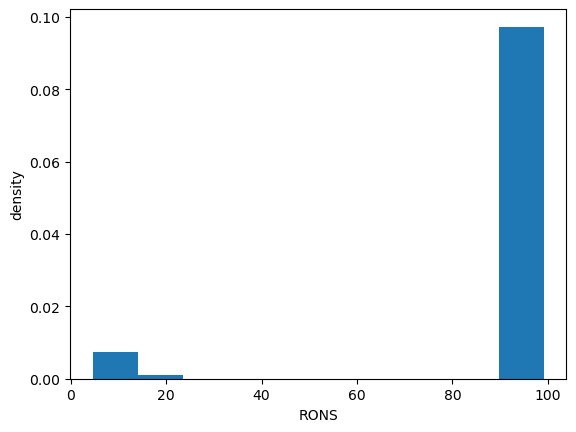

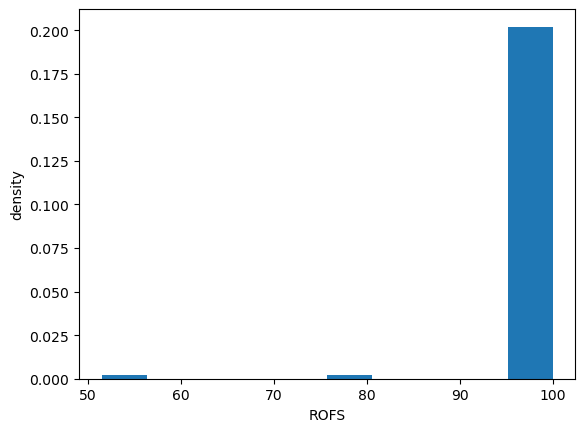

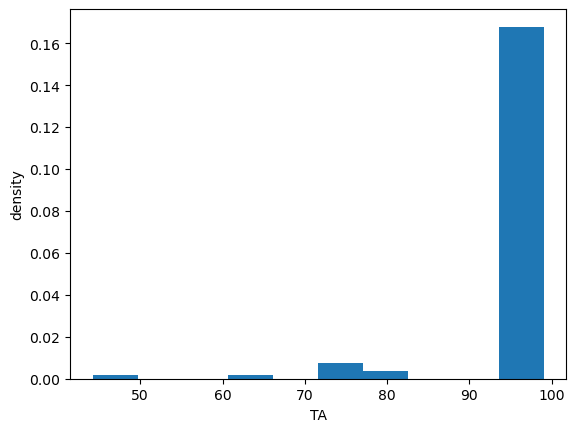

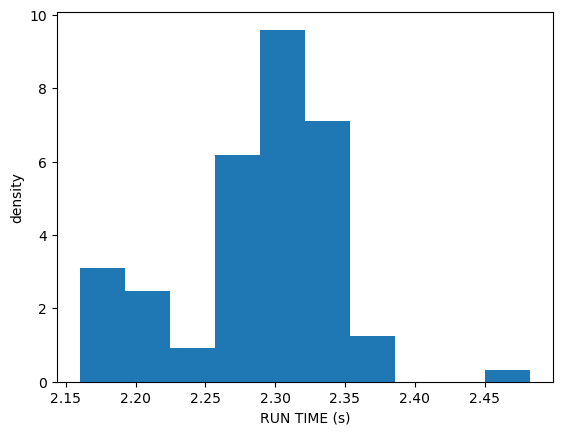

In [13]:
# read the results
df = pd.read_csv('validation_results/MJD/W_k_means/h_35_28/max_iter_600_tol_1e-08/p_100/validation_results.txt')

# Set the confidence level !
confidence_level = 0.95

rofs = df['ROFS'].values
rons = df['RONS'].values
ta = df['TA'].values
run_time = df['RUNTIME'].values
n_trials = len(ta)

rofs_bound = confidence_interval(rofs, confidence_level)
rons_bound = confidence_interval(rons, confidence_level)
ta_bound = confidence_interval(ta, confidence_level)
run_time_bound = confidence_interval(run_time, confidence_level)

plt.figure()
plt.hist(rons, bins=int(np.sqrt(n_trials)), density=True)
print(f'mean RONS = {np.mean(rons)} with {confidence_level*100}% CI = {rons_bound}')
plt.ylabel('density')
plt.xlabel('RONS')

plt.figure()
plt.hist(rofs, bins=int(np.sqrt(n_trials)), density=True)
print(f'mean ROFS = {np.mean(rofs)} with {confidence_level*100}% CI = {rofs_bound}')
plt.ylabel('density')
plt.xlabel('ROFS')

plt.figure()
plt.hist(ta, bins=int(np.sqrt(n_trials)), density=True)
print(f'mean TA = {np.mean(ta)} with {confidence_level*100}% CI = {ta_bound}')
plt.ylabel('density')
plt.xlabel('TA')


plt.figure()
plt.hist(run_time, bins=int(np.sqrt(n_trials)), density=True)
print(f'mean RUN TIME = {np.mean(run_time)} with {confidence_level*100}% CI = {run_time_bound}')
plt.ylabel('density')
plt.xlabel('RUN TIME (s)')

plt.show()

In [ ]:
print(f'correlation(RONS, ROFS) = {np.corrcoef(rons, rofs)[0, 1]}')
plt.scatter(rons, rofs)
plt.xlabel('RONS')
plt.ylabel('ROFS')

plt.show()

## Dependences from h1 and h2

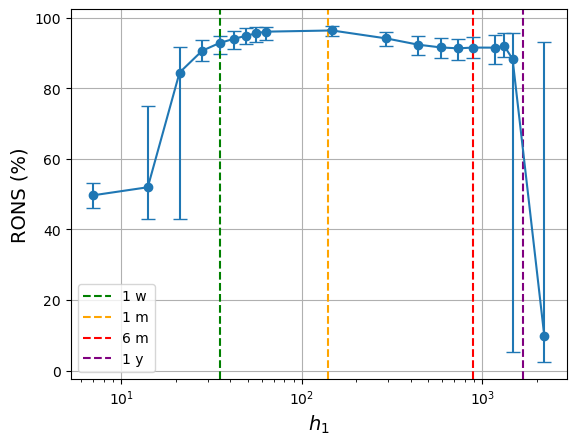

In [61]:
# with overlapping h2=int(h1*3/4)
x = np.array([7, 14, 21, 28, 35, 42, 49, 56, 63, 147, 294, 441, 588, 
              735, 882, 1176, 1323, 1470, 2205])

y = np.array([49.69, 51.96, 84.48, 90.65, 92.86, 94.04, 94.89, 95.64, 
              96.07, 96.41, 94.15, 92.38, 91.60, 91.34, 91.56, 91.54, 91.99,
             88.31, 9.66])

yerr = np.array([[46.17, 43.04, 42.89, 87.80, 89.60, 91.23, 92.48, 93.13, 
                  93.62, 94.94, 92.02, 89.40, 88.48, 88.05, 88.49, 86.97, 88.89,
                 5.21, 2.41],  
                 [53.06, 75.08, 91.82, 93.63, 94.95, 96.31, 97.06, 97.38, 
                  97.53, 97.67, 95.97, 94.85, 94.17, 93.97, 94.57, 95.11, 95.60,
                 95.79, 93.13]])
yerr[0] = y - yerr[0] 
yerr[1] = yerr[1] - y

#  scatter plot creation with error barr 
plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, linestyle='-')
plt.axvline(x=35, color='green', linestyle='--', label='1 w')
plt.axvline(x=35*4, color='orange', linestyle='--', label='1 m')
plt.axvline(x=882, color='red', linestyle='--', label='6 m')
plt.axvline(x=35*4*12, color='purple', linestyle='--', label='1 y')
plt.xlabel(f'$h_{1}$', size=14)
plt.ylabel('RONS (%)', size=14)
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

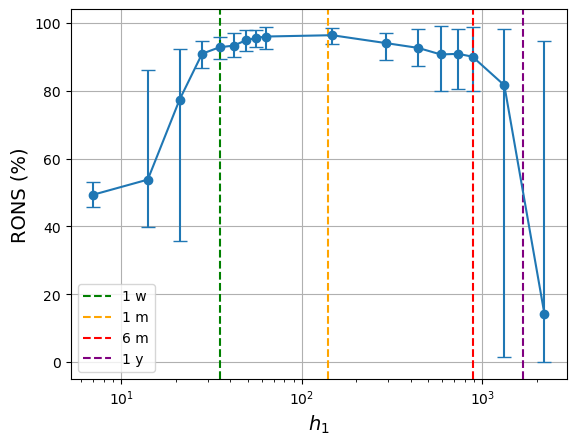

In [62]:
# without overlapping h2=0
x = np.array([7, 14, 21, 28, 35, 42, 49, 56, 63, 147, 294, 441, 588, 
              735, 882, 1323, 2205])

y = np.array([49.40, 53.84, 77.42, 91.00, 92.90, 93.40, 94.98, 95.66, 96.07,
              96.46, 94.11, 92.71, 90.78, 90.96, 90.12, 81.68, 14.30])

yerr = np.array([[45.70, 39.92, 35.64, 86.85, 89.51, 90.16, 91.69, 92.87, 92.29,
                 93.96, 89.03, 87.44, 80.11, 80.72, 80.08, 1.43, 0],  
                 [53.10, 86.29, 92.51, 94.77, 95.81, 97.02, 98.01, 98.08, 98.77,
                 98.67, 97.20, 98.20, 99.17, 98.25, 98.85, 98.26, 94.61]])
yerr[0] = y - yerr[0] 
yerr[1] = yerr[1] - y

# scatter plot creation with error barrs
plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, linestyle='-')
plt.axvline(x=35, color='green', linestyle='--', label='1 w')
plt.axvline(x=35*4, color='orange', linestyle='--', label='1 m')
plt.axvline(x=882, color='red', linestyle='--', label='6 m')
plt.axvline(x=35*4*12, color='purple', linestyle='--', label='1 y')
plt.xlabel(f'$h_{1}$', size=14)
plt.ylabel('RONS (%)', size=14)
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()